In [ ]:
%%capture install
try:
  import imlms
  print('Already installed')
except:
  %pip install git+https://github.com/Mads-PeterVC/imlms

In [ ]:
print(install.stdout.splitlines()[-1])

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Neural Networks

### Example: Linear Regression with a neural network

In [ ]:
from imlms.torch import get_example_data

X, y = get_example_data(n=10)

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1) # One input and one output

    def forward(self, x):
        return self.linear(x)

In [ ]:
model = LinearRegression()
y_pred_init = model(X).detach().numpy()

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1000):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: loss {loss.item()}')

y_pred_final = model(X).detach().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X, y)
ax.plot(X, y_pred_init, label='Initial prediction')
ax.plot(X, y_pred_final, label='Final prediction')

ax.legend()

plt.show()

### Exercise: More flexible architecture

In the cell below finish defining the model by completing the `forward`-function.

To do this, you should 

1. Call the first linear layer `linear_1` with the input `x` and assign that to `y`
2. Apply the activation function `torch.relu` to `y` and assign that to `y`

And then proceed to apply the second linear layer, an activation function and then the third linear layer 
and return the results. 

In [ ]:
class NonlinearRegression(torch.nn.Module):
    def __init__(self):
        super(NonlinearRegression, self).__init__()
        self.linear_1 = torch.nn.Linear(1, 16) # One input and 16 outputs
        self.linear_2 = torch.nn.Linear(16, 16) # 16 inputs and one output
        self.linear_3 = torch.nn.Linear(16, 1) # 16 inputs and one output

    def forward(self, x):            
        return x

Finish the training loop

In [ ]:
model = NonlinearRegression()
y_pred_init = model(X).detach().numpy()

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(10000):
    pass # Your code here

y_pred_final = model(X).detach().numpy()

You will see that the fit you get will be a little jagged. 

The model has gotten more expressive - but we always have to think whether it is a 
better model in general or if its a too complex model that is **overfitting**.

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X, y)
ax.plot(X, y_pred_init, label='Initial prediction')
ax.plot(X, y_pred_final, label='Final prediction')

ax.legend()

plt.show()

Try the following and see how it affects the fit

- Train the model for more steps and maybe with a lower learning rate
- Increase the number of neurons in each layer.
- Add an additional linear layer followed by an activation function to the network 

Because of the enourmous flexibility of neural networks to fit anything being vary of 
overfitting is important. 

Therefore it is generally not the performance on training data we use to judge whether a model works but 
the performance on a test data set. 

In [ ]:
X_test, y_test = get_example_data(n=25)
y_pred_test = model(X_test).detach().numpy()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

ax = axes[0]
ax.scatter(X, y)
ax.plot(X, y_pred_init, label='Initial prediction')
ax.plot(X, y_pred_final, label='Final prediction')
ax.legend()

ax = axes[1]
ax.scatter(X_test, y_test)
ax.plot(X_test, y_pred_test, label='Test prediction')
ax.legend()

plt.show()

### Exercise: Another dataset

The cell below defines another dataset (That you have seen before..)

Your task is to setup and train a neural network that can fit this dataset.

In [ ]:
from imlms.torch import get_damped_osc_dataset

X, y = get_damped_osc_dataset(n=10)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

X_test, y_test = get_damped_osc_dataset(n=50)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
# No help this time. You can do it!

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

y_pred_final = model(X).detach().numpy()
y_pred_test = model(X_test).detach().numpy()

ax = axes[0]
ax.scatter(X, y)
ax.plot(X, y_pred_final, label='Final prediction')
ax.legend()

ax = axes[1]
ax.scatter(X_test, y_test)
ax.plot(X_test, y_pred_test, label='Test prediction')
ax.legend()

plt.show()

### Example: Neural Network Pair Potential

Lets try fitting a pair potential with a neural network, well stary by getting some data

In [ ]:
from imlms.potentials.load_cluster_data import get_cluster_data

X, _, E = get_cluster_data(train=True)
X_test, _, E_test = get_cluster_data(train=False)

print(X.shape) # (n_samples, n_atoms, cartesian_coordinates)
print(E.shape) # (n_samples)

The data consists of 300 two-dimensional configurations each with 12 atoms and the corresponding total energies.

A pair potential is a potential where only the bond-length between pairs of atoms matters, like the 
Lennard Jones potential we worked with previously. So our neural network will be a function like 

$$
\mathrm{NN}_\theta(r) \rightarrow R^1
$$
Such that we can feed the network with all the bond distances and it predicts the energy for each bond. 
Finally, we can sum all these contributions together to get the total energy of a configuration. 

$$
E_{tot} = \sum_{r \in R} \mathrm{NN}_\theta(r)
$$
Where $R$ is understood to be the set of all distances in a configuration of atoms.

In [ ]:
class PairNN(torch.nn.Module):

    def __init__(self):
        super(PairNN, self).__init__()
        self.sequential_stack = torch.nn.Sequential(
            torch.nn.Linear(1, 16), # 1 input, 16 output
            torch.nn.SiLU(), # Look at torch documentation if you want to know what this is.
            torch.nn.Linear(16, 16), # 16 input, 16 output
            torch.nn.SiLU(),
            torch.nn.Linear(16, 1) # 16 input, 1 output
        )

    def forward(self, x):
        r = torch.pdist(x) # Get the pairwise distances

        # Put each distance through the model
        e = self.sequential_stack(r[:, None])
        return e.sum() # Sum over all pairs

We can define a nice little training loop function to train this network

In [ ]:
def training_loop(model, X_train, y_train, epochs=200, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    loss_per_epoch = torch.zeros(epochs)

    for epoch in tqdm(range(epochs)): # Loop over the dataset multiple times
        optimizer.zero_grad()   # Zero the gradients
        loss = 0                # Initialize the loss
        for xb, yb in zip(X_train, y_train):# Loop over the dataset
            E = model.forward(xb) # Compute the energy
            loss += loss_fn(E, yb)
        loss.backward()         # Compute the gradient
        optimizer.step()        # Update the parameters
        loss_per_epoch[epoch] = loss.item() / len(X_train) # Store the loss
        
    return loss_per_epoch

And finally we can try training the network 

In [ ]:
model = PairNN()
loss = training_loop(model, X, E, epochs=10000, lr=0.001)

Its a good idea to see how the loss has progressed as a function of epochs / gradient steps.

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(loss)
ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

And finally we can create a parity plot

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')

E_pred = torch.zeros_like(E)
for i, x in enumerate(X):
    E_pred[i] = model.forward(x)

E_test_pred = torch.zeros_like(E_test)
for i, x in enumerate(X_test):
    E_test_pred[i] = model.forward(x)

for ax, (E_true, E_model) in zip(axes, [(E, E_pred), (E_test, E_test_pred)]):
    ax.scatter(E_true, E_model.detach().numpy())
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax.plot(lim, lim, 'k--')
    ax.set_xlim(lim); ax.set_ylim(lim)

    ax.set_xlabel('True energy [eV]')
    ax.set_ylabel('Predicted energy [eV]')


plt.show()

### Exercise: Neural Network Pair Potential 

The data in the previous exercise comes a pair potential, so it can be modelled perfectly with 
a pair potential. 

However, now we will try a dataset where the energies have been calculated with DFT, 
as such it is very much not from a pair potential.

In [ ]:
from imlms.potentials.load_carbon_data import get_carbon_cluster_data
X, E = get_carbon_cluster_data(n=6) # n is the number of atoms in the cluster

Try fitting this dataset, you can play around with the parameters.

In [ ]:
# Create a model
# Train the model on the data

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(loss)
ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

E_pred = torch.zeros_like(E)
for i, x in enumerate(X):
    E_pred[i] = model.forward(x)

ax.scatter(E, E_pred.detach().numpy())
xlim = ax.get_xlim(); ylim = ax.get_ylim()
lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
ax.plot(lim, lim, 'k--')
ax.set_xlim(lim); ax.set_ylim(lim)

ax.set_xlabel('True energy [eV]')
ax.set_ylabel('Predicted energy [eV]')

plt.show()

### Exercise: Classification with a neural network

In [ ]:
from sklearn.datasets import make_classification

Classification is another type of supervised learning - one can think of it as discrete regression. 

The cell below generates a classification dataset and plots it.

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

X_np, y_np = make_classification(n_samples=100, n_features=2, 
                           n_classes=3, n_redundant=0, 
                           n_clusters_per_class=1, random_state=41)
ax.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis')

ax.set_ylabel('Feature 2')
ax.set_xlabel('Feature 1')

plt.show()

Now we will construct our neural network model for this classification task. 

In this case our network will be rather simple consisting of only two linear layers

1. The first layer should take the two dimensional input features and convert them to 16 dimensions. 

2. The second layer should convert the 16 dimensional representation to three dimensions - one for each of the classes. 

In between the two layers we will use a ReLU (`torch.relu`) activation function.

In order to make discrete predictions we will use **softmax**, illustrated below

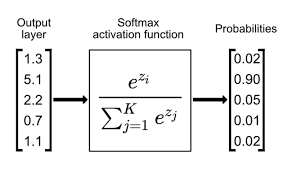

Softmax converts a set of numbers to probabilities proportional to the size of the numbers, e.g. 
in the figure 5.1 is the largest number and is converted to the largest probability. (If you have had statistical physics / thermodynamics you might see a similarity to e.g. the Boltzmann distribution - 
where the denominator is the partition function.)

With this we can have our network predict the probability of an example being of either of the classes. 
In order to make a final prediction we would then take the class with the highest probability

In torch we can use `torch.softmax` to apply softmax. 

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, n_features=2, n_classes=3, n_hidden=16):
        super(Model, self).__init__()
        # Your code here: Make the two linear layers.

    def forward(self, x):
        # Make the forward pass.
        pass # Replace with your code 
            
    def predict_probabilities(self, x):
        logits = self.forward(x)
        return torch.softmax(logits, dim=1)

    def predict_label(self, x):
        probs = self.predict_probabilities(x)
        return torch.argmax(probs, dim=1)

To test our model before training it, use the cell below to confirm the following

- The forward pass of the model when given a (1x2)-vector produces a (1x3)-vector of numbers.
- The `predict_probabilities` method produces a (1x3)-vector that sums to 1 and where the largest probability corresponds to the largest value produced by the forward pass. 
- The label predicted by `predict_label` is the index of the largest probability. 

In [ ]:
x = torch.tensor([[1.0, 2.0]])

model = Model()

logits = model(x).detach().numpy()
print(f"{logits = }")
probabilities = model.predict_probabilities(x).detach().numpy()
print(f"{probabilities = }")
print(f"{probabilities.sum() = }")

label = model.predict_label(x).item()
print(f"{label = }")


Now we will start training the model

In [ ]:
# Convert the dataset to tensors
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

Training the model is no different than any of the other models we can have tried, 
except we will use a different loss function. Namely, we will use what is called
cross-entropy. For two discrete probability distributions $p$ and $q$, cross entropy is given by

$$
H(p, q) = -\mathrm{E}_p [\log(q)] = - \sum_{x \in X} p(x) \log[q(x)]
$$

Where $\mathrm{E}_p$-denotes the expectation value under the distribution $p$.
We can dwell on the [det](https://en.wikipedia.org/wiki/Cross-entropy)-[ails](https://stackoverflow.com/questions/41990250/what-is-cross-entropy) or we can just accept this for now.

If we choose to accept it then using cross-entropy is easy as it is already available in 
pytorch using `torch.nn.CrossEntropyLoss`.

In [ ]:
model = Model()

# Loss function
criterion = torch.nn.CrossEntropyLoss() # This is the loss function we will use. 

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 201
for epoch in range(n_epochs):
    optimizer.zero_grad() # Zero the gradients
    y_pred = model(X) # Forward pass
    loss = criterion(y_pred, y) # Compute the loss
    loss.backward() # Compute the gradients of the loss
    optimizer.step() # Update the weights

    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

We can then make predictions

In [ ]:
predicted_labels = model.predict_label(X).detach().numpy()

And compare with the true labels

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis')
axes[1].scatter(X_np[:, 0], X_np[:, 1], c=predicted_labels, cmap='viridis')

Finally we can plot the decision boundaries of our model, or the regions in which 
each label will be predicted by our model.

In [ ]:
# Make a meshgrid
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1

dx = dy = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, dx),
                    np.arange(y_min, y_max, dy))

# Turn into tensor
X_mesh = torch.tensor(np.column_stack((xx.ravel(), yy.ravel())), dtype=torch.float32)

# Get the predicted labels
predicted_labels = model.predict_label(X_mesh).detach().numpy()

predicted_probs = model.predict_probabilities(X_mesh).detach().numpy()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(4*4, 4))

axes[0].pcolormesh(xx, yy, predicted_labels.reshape(xx.shape), cmap='viridis')

for i in range(3):
    ax = axes[i+1]
    c = ax.pcolormesh(xx, yy, predicted_probs[:, i].reshape(xx.shape), cmap='viridis', vmin=0.0, vmax=1.0)
    ax.set_title(f'Probability of class {i}')

plt.colorbar(c)

for ax in axes:
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
